# Lab5 - Training Deep Convolutional Neural Network
- นาย นันท์มนัส ตั้งประเสริฐ, 63070501040
- นาย สัณหณัฐ พรมจรรย์, 63070501069

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [ ]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from keras.utils import np_utils
from keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_accuracy'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    # labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class

# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)

            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

### 1. Load Cat vs. Dog dataset

In [ ]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2023-09-25 10:53:10--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.94.158, 52.217.224.48, 52.217.198.168, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.94.158|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

replace Cat_Dog_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
import os
import cv2

In [ ]:
# Define the path to your dataset
train_dir = '/content/Cat_Dog_data/train'
test_dir = '/content/Cat_Dog_data/test'

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

BATCH_SIZE = 32
IMG_SIZE = (128, 128)
# Create an Iterator object.
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binary classification (cat or dog)
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'  # Binary classification (cat or dog)
)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


### 2. Preprocess data

In [ ]:
# NOTE: This will work only if you are not using any data augmentation or shuffle in train_generator.
X_train = np.concatenate([train_generator[i][0] for i in range(len(train_generator))])
y_train = np.concatenate([train_generator[i][1] for i in range(len(train_generator))])

In [ ]:
# NOTE: This will work only if you are not using any data augmentation or shuffle in test_datagen.
X_test = np.concatenate([test_generator[i][0] for i in range(len(test_generator))])
y_test = np.concatenate([test_generator[i][1] for i in range(len(test_generator))])

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(22500, 128, 128, 3)
(22500,)
(2500, 128, 128, 3)
(2500,)


### 3. Build a convolutional neural network
Try to build a network that have a same or out perform our previous fully-connect model.

In [ ]:
# Define the model architecture
cnn = models.Sequential()
cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))
cnn.add(Conv2D(64, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((2, 2)))

cnn.add(Flatten())
cnn.add(Dense(512, activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.1))
cnn.add(BatchNormalization())
cnn.add(Dense(512, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(BatchNormalization())
cnn.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

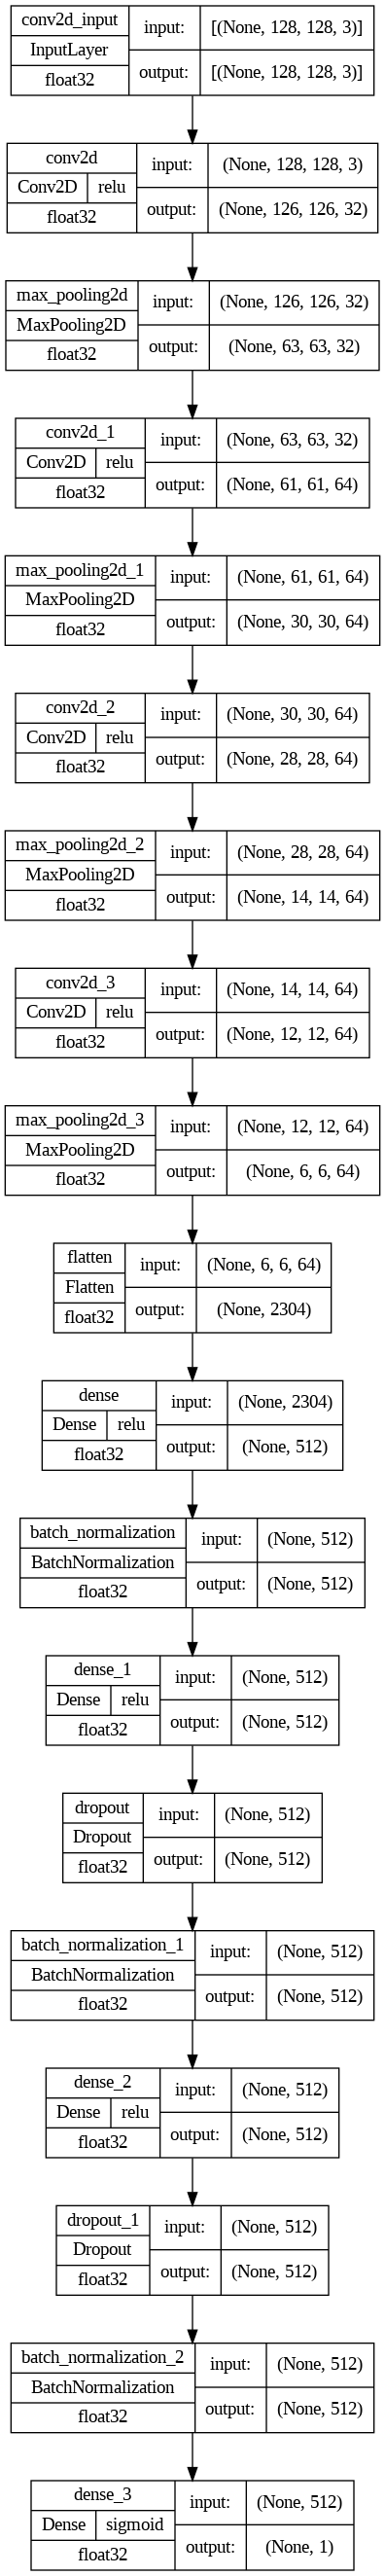

In [ ]:
keras.utils.plot_model(
    cnn,
    show_shapes=True,
    show_dtype=True,
    show_layer_activations=True
)

### 4. Trainig CNN Model

In [ ]:
# Define the early stopping criteria
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Now train the model with the early stopping callback
history = cnn.fit(train_generator,
                  epochs=20,
                  callbacks=[early_stop],
                  validation_data=test_generator)

Epoch 1/20
704/704 [==============================] - 442s 624ms/step - loss: 0.7119 - accuracy: 0.5798 - val_loss: 0.6760 - val_accuracy: 0.6096
Epoch 2/20
704/704 [==============================] - 435s 617ms/step - loss: 0.6498 - accuracy: 0.6315 - val_loss: 0.6867 - val_accuracy: 0.5812
Epoch 3/20
704/704 [==============================] - 433s 615ms/step - loss: 0.6090 - accuracy: 0.6717 - val_loss: 0.5813 - val_accuracy: 0.6980
Epoch 4/20
704/704 [==============================] - 438s 621ms/step - loss: 0.5712 - accuracy: 0.7057 - val_loss: 0.5727 - val_accuracy: 0.7336
Epoch 5/20
704/704 [==============================] - 440s 624ms/step - loss: 0.5428 - accuracy: 0.7258 - val_loss: 0.5315 - val_accuracy: 0.7652
Epoch 6/20
704/704 [==============================] - 432s 613ms/step - loss: 0.5114 - accuracy: 0.7524 - val_loss: 0.7109 - val_accuracy: 0.6692
Epoch 7/20
704/704 [==============================] - 429s 609ms/step - loss: 0.4797 - accuracy: 0.7738 - val_loss: 0.4591 -

Last train accuracy: 0.876800000667572
Last validation accuracy: 0.8952000141143799


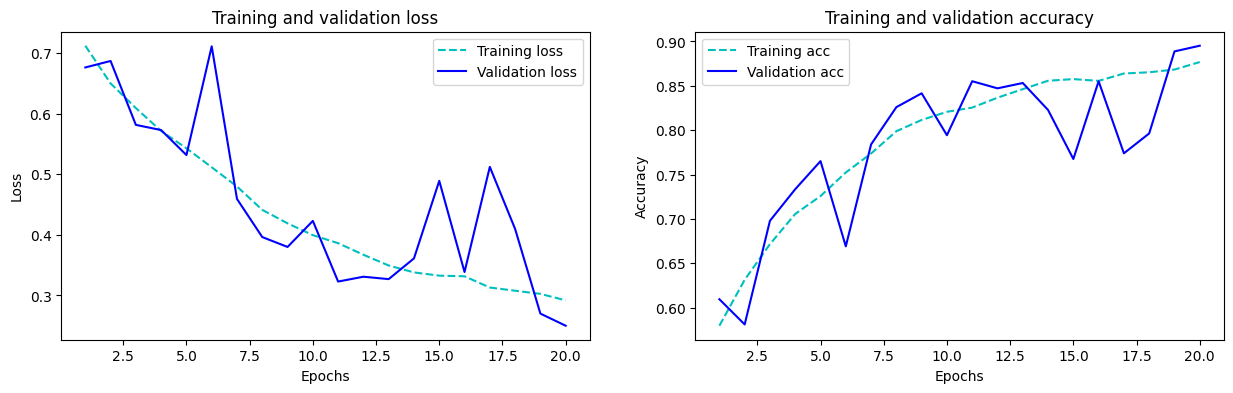

In [ ]:
show_result(history)

### 5. Evaluate your model
#### 5.1 Show the confusion matrix and classification report
Using function ```evaluation_report(model,feature,label)``` define above to print the classification report

In [ ]:
pred_class = evaluation_report(cnn,X_test,y_test)

79/79 [==============================] - 12s 151ms/step
[[1250    0]
 [1250    0]]
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67      1250
         1.0       0.00      0.00      0.00      1250

    accuracy                           0.50      2500
   macro avg       0.25      0.50      0.33      2500
weighted avg       0.25      0.50      0.33      2500

Loss: 0.2499995082616806 Accuracy: 0.8952000141143799


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 5.2 Show which image that your model incorrectly predict

Using function ```show_false_prediction(pred_class, actual_feature, actual_label)``` that is define above to show which image that your model predict wrong.

(1250, 128, 128, 3)


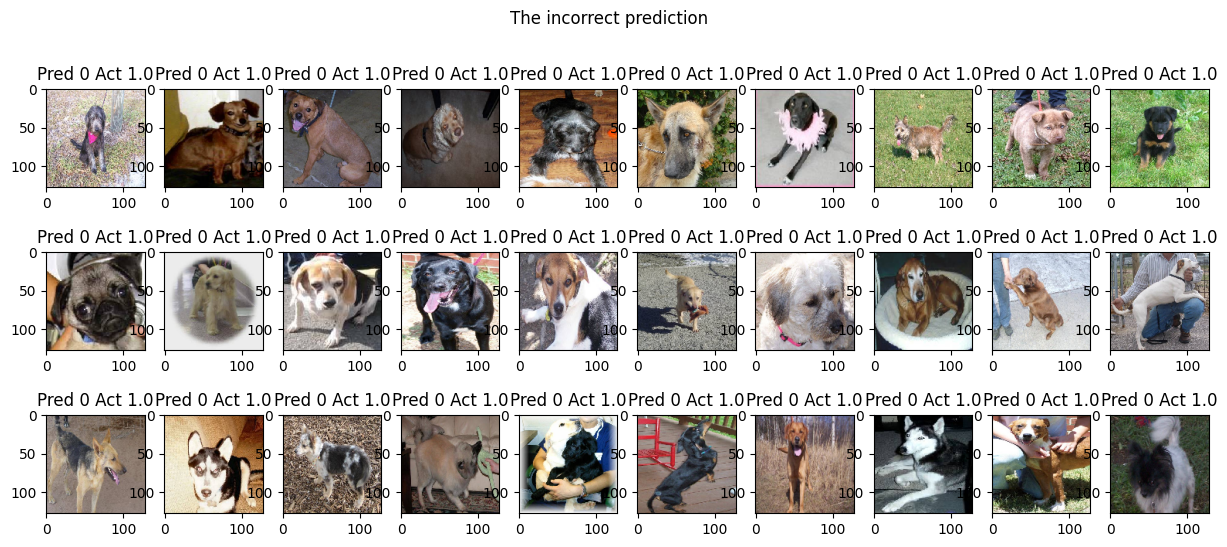

In [ ]:
show_false_prediction(pred_class, X_test, y_test,128,3)

1/1 [==============================] - 0s 28ms/step


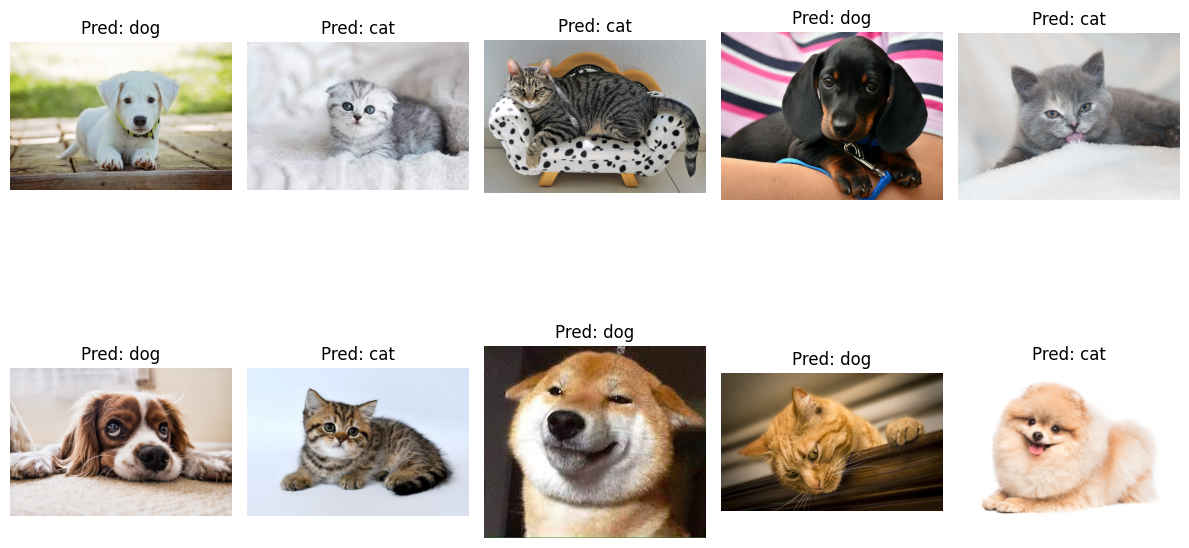

In [ ]:
# Define the directory containing the test images
test_images_dir = '/content/test_images'

image_files = [f for f in os.listdir(test_images_dir) if os.path.isfile(os.path.join(test_images_dir, f))]
label_map = {0: 'cat', 1: 'dog'}
plt.figure(figsize=(12, 8))

# Iterate through each image file and make predictions
for idx, image_file in enumerate(image_files, 1):
    img_path = os.path.join(test_images_dir, image_file)
    test_image = image.load_img(img_path, target_size=(128, 128))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)

    # Make predictions
    result = cnn.predict(test_image)

    predicted_class = 1 if result >= 0.5 else 0
    predicted_label = label_map[predicted_class]

    # Display the image along with the predicted label
    plt.subplot(2, len(image_files)//2, idx)
    plt.imshow(image.load_img(img_path))
    plt.title(f'Pred: {predicted_label}')
    plt.axis('off')

# Show the subplot with images and predicted labels
plt.tight_layout()
plt.show()